# Bundle Adjustment

Part of this assignment is based on scipy-cookbook. It will take around 2 hours to finish.

# Question 1: Reading

1. Read the paper 'Building Rome in a Day' and briefly write about the fundamental idea behind the problem and solution. No need to be verbose, just write about the challenge with the task and how the pipeline is implemented (do not include details about performance/parallelization).

    The problem is that we are given a set of images, we have to reconstruct its 3D world. The idea behind the problem lies around reconstructing a 3D place using collection of images of that place from the internet. For example, let's say we want to reconstruct a monument of Rome (As in the title of the paper), say Colosseum, we can search for it's images on the internet, get millions of images and use them to reconstrucct Colosseum as a 3D point cloud.

    The approach to this problem is as follows: First we find the correspondences between the images, which we can done using feature detection algorithms such as SIFT. Now we can use SfM(structure from motion) where we estimate the 3D points as well as the relative pose between the images. This is done by formulating the problem as an optimisation problem that minimises the total reprojection error.   

2. How is this task different from a SLAM problem?
    
    **SfM** : Our task involves using SfM algorithm to estimate 3D points. It's goal is to reconstruct 3D environment from series of 2D images.Here the requirement is that the he 2D images need to be taken from different positions so that we can get depth. Here the main sensor is a camera. This problem is solved through bundle adjustment. Here the 3D map estimated have scale paramter, that is the reconstruction is upto some scale. This is a computer vision problem.

    **SLAM** : In case of SLAM, our goal is to estimate sensor position and map of the robot and it's surroundings. It involves optimising path of a robot based on its given trajectory. In this case, main sensors are Lidar,IMU etc. This problem can also be solved with bundle adjustment approach. Here the 3D points estimated are exact, without any scaling.This is a robotics problem.

    SLAM and SfM can be related in the case when SLAM uses a camera as its sensor.
    
    Comparing this approach to vSLAM: In vSLAM problem, we are given an ordered set of images from a fixed camera setup, using which we . In this task, we are using SfM. In SfM we are given an unordered set of images usually taken from the internet, hence it might include different cameras. SfM approach can be applied on large datasets.

# Question 2: Code!

### Task
We have a set of points in real world defined by their coordinates $(X, Y, Z)$ in some apriori chosen "world coordinate frame". We photograph these points by different cameras, which are characterized by their orientation and translation relative to the world coordinate frame and also by focal length and two radial distortion parameters (9 parameters in total). Then we precicely measure 2-D coordinates $(x, y)$ of the points projected by the cameras on images. Our task is to refine 3-D coordinates of original points as well as camera parameters, by minimizing the sum of squares of reprojecting errors.

We will be using a dataset from http://grail.cs.washington.edu/projects/bal/ for this task. Feel free to choose any of the ones mentioned on the page. Take the smallest file from each dataset (you can choose any but it will take longer to run, consume more memory)

In [1]:
import urllib
import copy
import bz2
import os
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2021-12-02 01:29:38,896 - utils - NumExpr defaulting to 8 threads.


First download the data file:

Larger dataset:


In [2]:
# BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/"

# DATASET_NAME = "final/"
# FILE_NAME = "problem-13682-4456117-pre.txt.bz2"

# URL = BASE_URL + DATASET_NAME + FILE_NAME

Smaller dataset:

In [3]:
BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/"

DATASET_NAME = "venice/"
FILE_NAME = "problem-52-64053-pre.txt.bz2"

URL = BASE_URL + DATASET_NAME + FILE_NAME

In [4]:
if not os.path.isfile(FILE_NAME):
    urllib.request.urlretrieve(URL, FILE_NAME)

Now read the data from the file:

In [5]:
def read_bal_data(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

In [6]:
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data(FILE_NAME)

In [7]:
print(f"camera_params: {camera_params.shape};\npoints_3d: {points_3d.shape};\n"
        f"camera_indices: {camera_indices.shape}; \npoint_indices: {point_indices.shape}; \n"
        f"points_2d: {points_2d.shape}")

camera_params: (52, 9);
points_3d: (64053, 3);
camera_indices: (347173,); 
point_indices: (347173,); 
points_2d: (347173, 2)


Here we have numpy arrays:

1. `camera_params` with shape `(n_cameras, 9)` contains initial estimates of parameters for all cameras. First 3 components in each row form a **rotation vector**, next 3 components form a translation vector, then a focal distance and two distortion parameters.
2. `points_3d` with shape `(n_points, 3)` contains initial estimates of point coordinates in the world frame.
3. `points_2d` with shape `(n_observations, 2)` contains measured 2-D coordinates of points projected on images in all the observations.
4. `camera_ind` with shape `(n_observations,)` gives the index of the camera (from 0 to `n_cameras - 1`) associated with a particular observation.   
5. `point_ind` with shape `(n_observations,)` contains indices of 3D points (from 0 to `n_points - 1`) involved in each observation.

# Visualise Point Cloud

Visualise `points_3d`. It may not look like 'Venice' or any building as we are working with a small subset.

In [8]:
o3d_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points_3d))
o3d.visualization.draw_geometries([o3d_pcd])

# Extract Parameters

How many cameras and 3D points do we have? Calculate the number of parameters to estimate.

In [9]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]
m = 2 * points_2d.shape[0]
n = 9*n_cameras + 3*n_points

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters to estimate: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 52
n_points: 64053
Total number of parameters to estimate: 192627
Total number of residuals: 694346


We chose a relatively small problem to reduce computation time, but scipy's algorithm is capable of solving much larger problems, although required time will grow proportionally.

Now define the function which returns a vector of residuals. We use numpy vectorized computations:

### A short review on Transformations

Rodrigues Formula: $$\mathbf{R}=\cos \theta \mathbf{I}+(1-\cos \theta) \mathbf{n n}^{\mathrm{T}}+\sin \theta \mathbf{n}^{\wedge}$$
If described by a rotation vector, assuming that the rotation axis is a unit length vector $\mathbf{n}$ and the angle is $\theta$, then the vector $\theta \mathbf{n}$ can also describe this rotation. Here, rot_vecs = $\theta \mathbf{n}$.

In [10]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis] #np.newaxis converts this into a column vector.
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    return (cos_theta * points) + ((1 - cos_theta) * v * dot) + (sin_theta * np.cross(v, points))

## A short review on camera modelling & radial distortion



- Each pixel moves radially away from (barrel) or towards (pincushion) the image center (c).
- As a function of distance from $c: r_{c}^{2}=x_{c}^{2}+y_{c}^{2}$.
- The shift $\gamma$ can be modelled as: $\gamma=1+k_{1} r_{c}^{2}+k_{2} r_{c}^{4}$ where ${k}_{1}$ and ${k}_{2}$ are radial distortion parameters.
- The modified co-ordinates are:

$$\begin{array}{l}
\hat{x}_{c}=\gamma x_{c} \\
\hat{y}_{c}=\gamma y_{c}
\end{array} 
$$

- **This is applied before the focal-length multiplier and center shift are applied**: Meaning before $K$ matrix is even applied. But how do we exactly do that?

    $$\mathbf{K}=\left[\begin{array}{ccc}\alpha_{x} & 0 & x_{0} \\0 & \alpha_{y} & y_{0} \\0 & 0 & 1\end{array}\right] ; \qquad      \lambda {p} = \mathrm{x} =K[R \quad t] \mathrm{X}$$

    $$x_{final} = \gamma \left(\frac{f_0X}{Z}+c_x \right)
     \qquad \color{red} \bigotimes \textbf{wrong}$$

    $$x_{final} =  \left(f_0 \left(\gamma\frac{X}{Z} \right)+c_x \right)
     \qquad \color{surd} \checkmark \textbf{correct}$$

### Summing it up
Let $\pmb{P} = (X, Y, Z)^T$ - a radius-vector of a point, $\pmb{R}$ - a rotation matrix of a camera, $\pmb{t}$ - a translation vector of a camera, $f$ - its focal distance, $k_1, k_2$ - its distortion parameters. Then the reprojecting is done as follows:

\begin{align}
\pmb{Q} = \pmb{R} \pmb{P} + \pmb{t} \\
\pmb{q} = -\begin{pmatrix} Q_x / Q_z \\ Q_y / Q_z \end{pmatrix} \\
\pmb{p} = f (1 + k_1 \lVert \pmb{q} \rVert^2 + k_2 \lVert \pmb{q} \rVert^4) \pmb{q}
\end{align}

![radial_distortion_3.png](../misc/form.jpeg)   
The resulting vector $\pmb{p}=(x, y)^T$ contains image coordinates of the original point.  
![radial_distortion_1.png](../misc/radial_distortion_1.png) 
![radial_distortion_2.png](../misc/radial_distortion_2.png)

In [11]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    
    #First perform rotation: Q = RP + t
    rot_vecs  = camera_params[:,0:3]
    t = camera_params[:,3:6]
    Q = rotate(points,rot_vecs) + t    
    
    #Now define q:
    q = -1*np.vstack((Q[:,0]/Q[:,2],Q[:,1]/Q[:,2]))
    q = q.T

    #Now get p: p = f*(1+k1*q_norm**2+k2*q_norm**4)*q
    f = camera_params[:,6]
    k1 = camera_params[:,7]
    k2 = camera_params[:,8]
    q_norm_sq = np.sum(q**2,axis=1)
    val = f*(1 + k1*q_norm_sq + k2*q_norm_sq**2)
    p = np.c_[val*q[:,0],val*q[:,1]]
    return p

In [12]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    params = copy.deepcopy(params)
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

## A short review on Structure from Motion
### Residual
In our lecture, in the residual vector, we  wrote the elements in order: 11, 12, 13.., 1N, then 21, 22.. and so on till MN. However, notice that it is not the case here.

M -> camera, N -> 3D point (in our lectures, NOT in this code)
![sfm_residual_1.png](../misc/sfm_residual_1.png)

You can see that computing Jacobian of `fun` is cumbersome, thus we will rely on the finite difference approximation. To make this process time feasible we provide Jacobian sparsity structure (i. e. mark elements which are known to be non-zero):

![sfm_jac_2.png](../misc/sfm_jac_2.png)

Since the matrix is sparse, we can make use of datastructures that are meant for such a usecase - https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html.

In [13]:
from scipy.sparse import lil_matrix

The code for the matrix computation has been given to you, you will have to explain this function later on.

In [14]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2 
    n =  n_cameras * 9 + n_points * 3
        
    A = lil_matrix((m, n), dtype=int)

    camera_indices = np.sort(camera_indices)
    point_indices = np.sort(point_indices)
    
    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1
            
    return A

### THAT'S IT! Now we are ready to use inbuilt library functions!
Now we are ready to run optimization. Let's visualize residuals evaluated with the initial parameters.

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

In [16]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

In [17]:
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

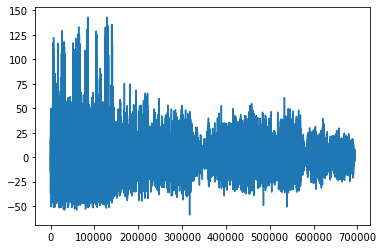

In [18]:
plt.plot(f0)

In [19]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
print(A.shape, n_cameras, n_points)

(694346, 192627) 52 64053


### Optimization

Scipy has existing functions for optimization that we can make use of. Write a sentence about the method that is used for optimization

scipy.optimize.least_squares - solves a non-linear least squares problem. It takes a function `fun` as input which computes residuals, and it takes x0 as input which contains initialisations.

In [20]:
import time
from scipy.optimize import least_squares

In [21]:
t0 = time.time()
# So far: method='lm'
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1152e+07                                    2.02e+07    
       1              2         1.0763e+07      3.89e+05       4.04e+01       2.60e+07    
       2              4         1.0686e+07      7.75e+04       4.58e+00       2.64e+07    
       3              5         1.0679e+07      6.47e+03       1.15e+00       2.65e+07    
       4              6         1.0678e+07      8.18e+02       2.87e-01       2.66e+07    
       5              7         1.0678e+07      1.54e+02       7.19e-02       2.66e+07    
       6              8         1.0678e+07      3.55e+01       1.80e-02       2.66e+07    
       7              9         1.0678e+07      8.67e+00       4.49e-03       2.66e+07    
       8             10         1.0678e+07      2.16e+00       1.12e-03       2.66e+07    
       9             11         1.0678e+07      5.38e-01       2.81e-04       2.66e+07    

In [22]:
params = res.x

new_camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
new_points_3d = params[n_cameras * 9:].reshape((n_points, 3))

### Plot Optimised Points

In [23]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(new_points_3d)
o3d.visualization.draw_geometries([pcd])

Setting `scaling='jac'` was done to automatically scale the variables and equalize their influence on the cost function (clearly the camera parameters and coordinates of the points are very different entities). This option turned out to be crucial for successfull bundle adjustment.

In [24]:
print("Optimization took {0:.0f} seconds".format(t1 - t0))

Optimization took 58 seconds


Now let's plot residuals at the found solution:

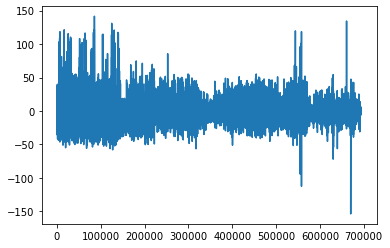

In [25]:
plt.plot(res.fun)

We see much better picture of residuals now, with the mean being very close to zero. There are some spikes left. It can be explained by outliers in the data, or, possibly, the algorithm found a local minimum (very good one though) or didn't converged enough. Note that the algorithm worked with Jacobian finite difference aproximate, which can potentially block the progress near the minimum because of insufficient accuracy (but again, computing exact Jacobian for this problem is quite difficult).

### Project 2- Part B: Submission details -
You are supposed to gain understanding by playing around with the code above and submit your answers to questions asked below. You shouldn't submit this whole notebook, just copy the following cells (starting next cell up until the end of this notebook) and paste it at the end of your Project 2 notebook (already shared on GitHub classrooms, [link](https://github.com/AryanSakaria/Project_2/blob/main/Project_2.ipynb)).

# Theory

## 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - Ans-1 - Basics: We are given a series of images, let's call them $$I_1,I_2,I_3...$$ 
    In practical settings, we know which image was captured by which camera (camera is distinguished by it's K and it's pose). Now points_2d contains 2d points across all images, we can use feature detection techniques to get correspondece between points_2d and image point. After doing this, as we already have correspondences between image and cameras, and we found correspondences between  points_2d and images, we now know which camera corresponds to which points_2d.
    
2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - Ans-2 - Basics: 'point_ind' stores the index of the 3D point for each 2D point.   We can know it as  follows:    
    First we will detect features common between the images, which is done using feature detection techniques such as SIFT, ORB etc... Now we can use these matched correspondences to estimate fundamental matrix (using alogrithms like 8 point algorithm), which can then be decomposed to get Rotation and translation between the images.     
    Now we can use triangulation as : take two pixels $x_1$ and $x_2$, and get the 3D point(let's call it $X$) corresponding to them. So by this approach, we know both these pixels $x_1$ and $x_2$ correspond to $X$. 
    
3. `0.5 mark` **Transformations** - `rotate()` function: Why do we use the rodriquez formula? How is this representation different from the standard 3x3 Rotation matrix, why do we use this instead?
    - Ans-3 - Transformations: Rodrigue's formula interprets rotation of a point $P$ as $P$ being rotated about a fixed axis $n$ by an angle $\theta$. This is different from our standard Rotation matrix as in the standard case, we transform a point by multiplying them with 3x3 rotation matrix(R). So in the case of Rodrigue, we do not need a 3x3 matrix, we just need 3 parameters: 2 for rotation vector(because the third can be calculated from other 2, as this vector is unit vector) and 1 for theta. 
    Rodrigues' approach can be used to calculate Rotation matrix(R) as:

    $$\mathbf{R}=\cos \theta \mathbf{I}+(1-\cos \theta) \mathbf{n n}^{\mathrm{T}}+\sin \theta \mathbf{n}^{\wedge}$$

    We do this because in his case, we are given camera_params matrix(3x3) which contains total 9 parameters(including the 3 parameters required for rotation by rodrigues). In our lecture, we were given projection matrix(3x4), which has total 12 parameters (this is because it contains R,t and K). So here in total we have $9*n_{cameras}$ parameters to estimate, whereas in case of 3x3 rotaion matrix we have $12*n_{cameras}$ parameters to estimate.

    
4. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - Ans-4 - Transformations: Yes, it would make a difference if we translated first and then rotated.    
    We are given 3D points in the world frame, and to project them onto an image $I_i$, we need to bring the points to the camera $C_i$'s frame. Now to transform the 3D world points into the camera's frame, we have:      
    $P_w$ - point in world frame    
    $R^{c}_{w}$ - camera to world rotation matrix  
    $tc^{c}_{w}$ - camera to world translation vector in **camera's frame**  
    $P_c$ - point in camera frame  

    If we translate first and then rotate:  
    $$ P_c = R^{c}_{w} (P_w + tc^{c}_{w})$$
    This is **incorrect** because we are adding the two vectors $P_w$ and $tc^{c}_{w}$, both of which are in differnt frames (world frame and camera's frame respectively), and two vectors can only be added when they are in the same frame.  

    If we rotate first and then translate:
    $$ P_c = R^{c}_{w} (P_w) + tc^{c}_{w}$$
    This is **correct** because we are first bringing the vector $P_w$ in camera's frame(with shifted origin) by multiplying it with $R^{c}_{w}$. This gives us the point $P_w$ in a frame which is aligned with the camera's frame. Having done so, we just need to shift the origin for this vector $R^{c}_{w} (P_w)$ by using tc^{c}_{w}.

    **The first approach would have been correct if** translation vector defined to us was in **world's frame**. So in that case, we have:
    $tw^{c}_{w}$ - camera to world translation vector in **world's frame** 
    $$ P_c = R^{c}_{w} (P_w + tw^{c}_{w})$$
    $$ P_c = R^{c}_{w} P_w + R^{c}_{w}tw^{c}_{w}$$

    Now here, the second term contains $R^{c}_{w}$ and $tw^{c}_{w}$ together, which will change the structure of our jacobian. But what we can do is define the second term as a new parameter $t_new$, and then estimate $R^{c}_{w}$ and $t_{new}$. But as we can see, $$t_{new} = tc^{c}_{w} = R^{c}_{w}tw^{c}_{w}$$
    Hence we are essentially back to the second approach , which we have used in `project()`.

        
5. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - Ans-5 - Jacobian: We have:  
    $$m = total number of 2D points$$
    $$N = total number of 3D points$$
    $$M = total number of images$$

    The residual is defined as the error in given 2D points and the estimated 2D points. So the number of residuals is equal to the number of 2D points.  Now, the jacobian consists of derivatives of the residuals,as its rows. 
    **In theory**, we take all the 2D points formed because of projecting all $N$ 3D points on all $M$ cameras. Hence we have $(N*M)$ 2D points in total, and since each 2D point has two parameters ($x$ and $y$), we have total of $(2*M*N)$ residuals. Hence first dimension of jacobian is $(2*M*N)$. 
    **In this case**, we are already given $m$ 2D points (which are a subset of maximum possible 2D points, having size $(N*M)$). Hence as we have $m$ 2D points, and each point corresponds to 2 parameters($x$ and $y$), we have total of $(2*m)$ residuals.
    
6. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes. 
        - Ans 6.1 - Jacobian & Parameters: 
        We know that the total number of parameters to estimate are given by:  
        
        Total_params = number of camera parameters * number of cameras + 3 * number of 3D points  

        Here we are given `camera_params` for each camera, which is a 3x3 matrix and contains the parameters of the camera. This matrix contains 9 parameters: 3 for rotation, 3 for translation, 1 for focal length and remaining 2 for distortion. Since there are total `n_cameras`, we have $9*n_{cameras}$ parameters to estimate for the camera part. Apart from this, there are $3*n_{points}$ paramters because of 3D points. Hence in total we have $9*n_{cameras} + 3*n_{points}$ parameters to estimate.   

        In our lecture, we were given the projection matrix, which is 3x4 matrix, and contains the parameters of the camera. This matrix contains 12 parameters in total: it contains 3x3 rotation matrix, translation vector and 3x3 camera intrinsics matrix. Since there are total `n_cameras`, we have $12*n_{cameras}$ parameters to estimate for the camera part. Apart from this, there are $3*n_{points}$ paramters because of 3D points. Hence in total we have $12*n_{cameras} + 3*n_{points}$ parameters to estimate.

        We can see that using the axis-angle representation instead of rotation matrix representation, we were able to reduce the number of paramters to estimate, by $12*n_{cameras} - 9*n_{cameras} = 3*n_{cameras}$.

        
    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        - Ans 6.2 - Jacobian & Parameters: As explained in the previous part:  
        
        **In our lecture notes,**we were given the projection matrix, which is 3x4 matrix, and contains the parameters of the camera. This matrix contains 12 parameters in total. Since there are total `n_cameras`, we have $12*n_{cameras}$ parameters to estimate for the camera part. Apart from this, there are 3 co-ordinates to estimate for each 3D point, and as there are $n_points$ number of 3D points, there are $3*n_{points}$ paramters to estimate for the points part. Hence in total we have $12*n_{cameras} + 3*n_{points}$ parameters to estimate.
        
        **Here in the code,** we are given `camera_params` for each camera, which is a 3x3 matrix and contains the parameters of the camera. This matrix contains 9 parameters: 3 for rotation, 3 for translation, 1 for focal length and remaining 2 for distortion. Since there are total `n_cameras`, we have $9*n_{cameras}$ parameters to estimate for the camera part. Apart from this, there are 3 co-ordinates to estimate for each 3D point, and as there are $n_points$ number of 3D points, there are $3*n_{points}$ paramters to estimate for the points part. Hence in total we have $9*n_{cameras} + 3*n_{points}$ parameters to estimate.   
            
7. `6 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.) For the toy example, you can take something like 3 points all seen from 3 cameras. (You don't actually have to code much, just need to call the existing function) Write that toy example after this cell
    - Ans 7 - Sparsity, Residual Vector & Jacobian: We understand the following:    
    First we define number of rows $m$ and number of columns $n$.     
    As explained previously, the number of rows will be equal to the number of residuals. As there are `camera_indices.size` number of 2D points, and each 2D point provied 2 residuals (each for x and y co-ordinate), we have a total of $2*$`camera_indices.size` residuals, hence we will have $m = $2*$`camera_indices.size`.    
    Now, the number of columns in jacobian will be equal to the number of parameters we are estimating. As explained previously, there are $9*n_{cameras} + 3*n_{points}$ parameters to estimate, hence we will have $n = 9*n_{cameras} + 3*n_{points}$.    

    The columns of the Jacobian are filled in order: first part corresponds to 'motion', while second part corresponds to 'structrue'. So the first for loop fills the 'motion' part of the Jacobian while the second loop fills the 'structure' part of the jacobian.

    Now we will take 3 world points, which are captured through 3 cameras. So now we have 3x3 = 9 image points (considering all world points map to all images). We can define some `camera_indices` and `point_indices`. Now the code is given below:  
    

    


In [35]:
n_points = 3
n_cameras = 3

camera_indices = np.zeros(n_points*n_cameras)
for i in range(n_points):
    for j in range(n_cameras):
        camera_indices[n_points*i+j] = i
print("Camera indices:", camera_indices)

point_indices = np.zeros(n_points*n_cameras)
for i in range(n_points):
    for j in range(n_cameras):
        point_indices[n_points*i+j] = j
print("Point indices:", point_indices)

A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
print("Jacobian matrix:\n\n", A.toarray())

Camera indices: [0. 0. 0. 1. 1. 1. 2. 2. 2.]
Point indices: [0. 1. 2. 0. 1. 2. 0. 1. 2.]
Jacobian matrix:

 [[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1

## 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers).

We will proceed in the following manner:

1. First we will perform feature matching between the images. It can be done using SIFT.  

    `sift = cv2.SIFT_create()`     
    `key1, desc1 = sift.detectAndCompute(img1, None)  `  
    `key2, desc2 = sift.detectAndCompute(img2, None)  `    

    So this gives us the keypoints and the corresponding descriptions for the two images. Having found the descriptors, we will use  `Matcher_Object.match()` to match these two images.

    The points stored in matches are separated into pts1 and pts2.
        

2. So now we have the corresponding points, we can compute the essential matrix. It can be done using `cv2.     findEssentialMatrix`, which takes pts1,pts2 and K as input. The parameters provided are the lists of matching points, `pts1` and `pts2` as well as the camera intrinsics, `K`.    

3. Now we will decompose the essential matrix into R and t as:

    `R,t = cv2.recoverPose(E, pts1, pts2, K)`  

    where:  
    E = Essential Matrix   
    pts1 = points from first image  
    pts2 = points form second image  
    K = camera intrinsics matrix  

    The output of rotation is stored in R and the output of translation is stored in t.   

4. Finally, as we have decomposed E to get R and t, we can get the 3D points as:    

    ```python
    Pw = cv2.triangulatePoints(P1, P2, pts1, pts2) # triangulate back the points
    ```
    Where P1 is the projection matrix of first camera and P2 is the projection matrix of second camera.
    Pw contains the points as homogeneous co-ordinates in the first frame, which can be converted to stand co-ordinates.